In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import os
import logging
import matplotlib.pyplot as plt
import cv2

import torch
import torch.optim
import torch.utils.data
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import open3d as o3d

from tensorboardX import SummaryWriter
from utils.utils import getWriterPath
from settings import EXPER_PATH
from utils.loader import dataLoader, modelLoader, pretrainedLoader
from utils.logging import *
from copy import deepcopy as dc
from utils.d2s import DepthToSpace, SpaceToDepth
from train_cubemap import *
from utils.utils import flattenDetection
from Train_model_frontend_cubemap import thd_img

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def showim(imgs):
    plt.figure()
    if not type(imgs) == list:
        imgs = [imgs]
    for img in imgs:
        try:
            img = img.detach().cpu().numpy()
        except:
            img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    
    
args = Namespace(command='train_joint', config='configs/magicpoint_cubemap.yaml', debug=False, eval=False, exper_name='cubemap_dataset', func=train_joint)


with open(args.config, 'r') as f:
    config = yaml.safe_load(f)
output_dir = os.path.join(EXPER_PATH, args.exper_name)
output_dir

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'logs/cubemap_dataset'

In [2]:
############################################### train_joint

torch.set_default_tensor_type(torch.FloatTensor)
task = config['data']['dataset']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info('train on device: %s', device)
with open(os.path.join(output_dir, 'config.yml'), 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
# writer = SummaryWriter(getWriterPath(task=args.command, date=True))
writer = SummaryWriter(getWriterPath(task=args.command, 
    exper_name=args.exper_name, date=True))
## save data
save_path = get_save_path(output_dir)

############################################### 
data = dataLoader(config, dataset=task, warp_input=True)
train_loader, val_loader = data['train_loader'], data['val_loader']

datasize(train_loader, config, tag='train')
datasize(val_loader, config, tag='val')
# init the training agent using config file
# from train_model_frontend import Train_model_frontend
from utils.loader import get_module
train_model_frontend = get_module('', config['front_end_model'])
train_agent = train_model_frontend(config, save_path=save_path, device=device)

# writer from tensorboard
train_agent.writer = writer

# feed the data into the agent
train_agent.train_loader = train_loader
train_agent.val_loader = val_loader

# load model initiates the model and load the pretrained model (if any)
train_agent.loadModel()
train_agent.dataParallel()


2023-03-28 13:39:41 koala-A520M-H root[115845] INFO train on device: cuda
2023-03-28 13:39:41 koala-A520M-H root[115845] INFO => will save everything to logs/cubemap_dataset/checkpoints
2023-03-28 13:39:41 koala-A520M-H root[115845] INFO workers_train: 1, workers_val: 1


dataset: CubemapDataset


2023-03-28 13:39:42 koala-A520M-H root[115845] INFO == train split size 64800 in 64800 batches
2023-03-28 13:39:42 koala-A520M-H root[115845] INFO == val split size 64800 in 64800 batches
2023-03-28 13:39:42 koala-A520M-H root[115845] INFO => creating model: SuperPointNet_cubemap


Load Train_model_frontend!!
check config!! {'train_iter': 200000, 'save_interval': 2000, 'tensorboard_interval': 1000, 'model': {'subpixel': {'enable': False}, 'train_only_descriptor': True, 'name': 'SuperPointNet_cubemap', 'params': {}, 'detector_loss': {'loss_type': 'softmax'}, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'kernel_reg': 0.0, 'detection_threshold': 0.001, 'nms': 4, 'dense_loss': {'enable': False, 'params': {'descriptor_dist': 4, 'lambda_d': 800}}, 'sparse_loss': {'enable': True, 'params': {'num_matching_attempts': 1000, 'num_masked_non_matches_per_match': 100, 'lamda_d': 1, 'dist': 'cos', 'method': '2d'}}, 'other_settings': 'train 2d, gauss 0.5'}, 'data': {'dataset': 'CubemapDataset', 'primitives': 'all', 'preprocessing': {'blur_size': 21, 'resize': None}, 'augmentation': {'photometric': {'enable': True, 'enable_train': True, 'enable_val': False, 'primitives': ['random_brightness', 'random_contrast', 'additive_speckle_noise', 'additive_gaussian_noise'

2023-03-28 13:39:43 koala-A520M-H root[115845] INFO => setting adam solver
2023-03-28 13:39:43 koala-A520M-H root[115845] INFO reset iterations to 0


adam optimizer
load pretrained model from: %s logs/magicpoint_synth_t2/checkpoints/3channel.pth.tar
successfully load pretrained model from: %s logs/magicpoint_synth_t2/checkpoints/3channel.pth.tar
=== Let's use 1 GPUs!
adam optimizer


In [3]:
sample =next(iter(train_loader))

/home/koala/pnp/pytorch-superpoint/datasets/CubemapDataset.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.sizer == 'No resize':


In [4]:
sample.keys()

dict_keys(['image', 'warped_image', 'ply_path', 'R', 'T', 'R_w', 'T_w', 'img_path', 'img_path_w', 'kpts2D', 'kpts3D', 'kpts2D_w', 'kpts3D_w'])

In [5]:
net = dc(train_agent.net)
img, img_w = sample['image'].to(device), sample['warped_image'].to(device)

out = net(img)
out_w = net(img_w)

In [6]:
b=0
w = sample['kpts3D'][b]
w_w = sample['kpts3D_w'][b]
w = w[torch.where(w[:, 0]>0)[0]]
w_w = w_w[torch.where(w_w[:, 0]>0)[0]]

idxs1, idxs2 = [],[]
for i1, k1 in enumerate(w):
    for i2, k2 in enumerate(w_w):
        if torch.sum(torch.abs(k1-k2)) < 5.0e-2:
#             print(k1, k2)
            idxs1.append(i1)
            idxs2.append(i2)


In [7]:
kp2d = sample['kpts2D'][b]

In [8]:
out['desc'].shape

torch.Size([1, 256, 256, 256])

In [9]:
out['semi'].shape

torch.Size([1, 65, 256, 256])

In [10]:
train_agent.interpolate_to_dense(out['desc']).shape

torch.Size([1, 256, 2048, 2048])

In [11]:
sample['kpts2D'][0][idxs1[1]], sample['kpts2D_w'][0][idxs2[1]]

(tensor([1464.,  214.], dtype=torch.float64),
 tensor([1574.,  180.], dtype=torch.float64))

In [12]:

# out['desc'] to kpt
thd = 0.4
hms = thd_img(flattenDetection(out['semi']), thd=thd)
hms_w = thd_img(flattenDetection(out_w['semi']), thd=thd)
rs, cs = torch.where(hms[b][0] > 0)
kpts = torch.stack((cs, rs), dim=1)
rs_w, cs_w = torch.where(hms_w[b][0] > 0)
kpts_w = torch.stack((cs_w, rs_w), dim=1)

dbs= sample['kpts2D'][b].to(device)
dbs_w= sample['kpts2D_w'][b].to(device)
c = 0

# kpts = kpts[:10]
# kpts_w = kpts_w[:10]

# get output 3D kpts
output_kpts_idx = []
output_3Dcoor = []
dbslist = dbs.detach().cpu().tolist()
dbslist_w = dbs_w.detach().cpu().tolist()
for i, pt in enumerate(kpts.detach().cpu().tolist()):
    if pt in dbslist:
        output_kpts_idx.append(i)            # output_kpts_idx: [2, 3, 5, 6, 7, 9, ...] db에 있는 kpt 인덱스
        output_3Dcoor.append(sample['kpts3D'][b][dbslist.index(pt)])   # [2번의3D좌표, 3번의 3D좌표, 5번의 3D좌표, ...]
        c += 1

output_kpts_idx_w = []
output_3Dcoor_w = []
c2 = 0
print()
for i, pt_w in enumerate(kpts_w.detach().cpu().tolist()):
    if pt_w in dbslist_w:
        output_kpts_idx_w.append(i)
        output_3Dcoor_w.append(sample['kpts3D_w'][b][dbslist_w.index(pt_w)])
        c2+=1
        
c, c2, len(kpts), len(kpts_w)

(213, 220, 338, 364)

In [70]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize(imname1, imname2, kpts1, kpts2, n=3):
    im1, im2 = np.array(Image.open(imname1)), np.array(Image.open(imname2))
    R = 2
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0
    for x, y in kpts1:
        ax[0].add_patch(plt.Circle((x, y), R, color='r'))
        ax[0].text(x, y, str(i))
        i += 1
        if i>=n:
            break
            
    ax[0].text(0, 100, '(0, 100)')
    ax[0].text(0, 0, '(0, 0)')
    i=0
    ax[1].imshow(im2)
    for x, y in kpts2:
        ax[1].add_patch(plt.Circle((x, y), R, color='r'))
        ax[1].text(x, y, str(i))
        i += 1
        if i>=n:
            break
    plt.savefig('sample.png')


115 points


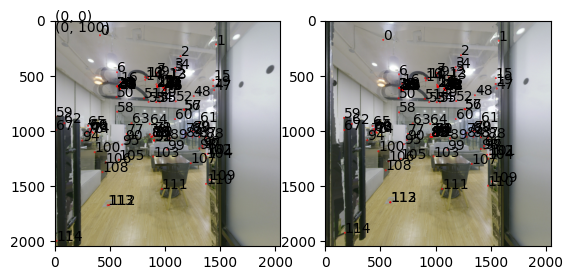

In [71]:
# match 3D_kpt and 3d_kpt_w

matched_idx, matched_idx_w = [], []
for i1, k1 in enumerate(output_3Dcoor):
    for i2, k2 in enumerate(output_3Dcoor_w):
        if torch.sum(torch.abs(k1-k2)) < 5.0e-2:
#             print(k1, k2)
            matched_idx.append(i1)
            matched_idx_w.append(i2)
print(len(matched_idx), "points")
matched_kpts_idx = torch.Tensor(output_kpts_idx)[matched_idx]
matched_kpts_idx_w = torch.Tensor(output_kpts_idx_w)[matched_idx_w]

visualize(sample['img_path'][b], sample['img_path_w'][b], 
          kpts[matched_kpts_idx.int()], kpts_w[matched_kpts_idx_w.int()], n=1000)

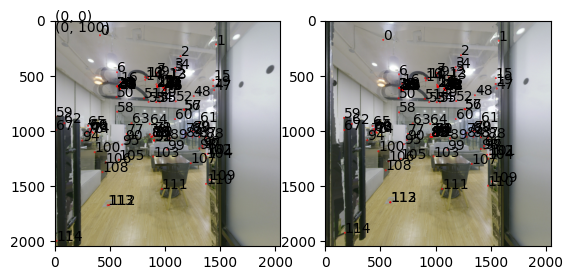

In [65]:

visualize(sample['img_path'][b], sample['img_path_w'][b], 
          kpts[matched_kpts_idx.int()], kpts_w[matched_kpts_idx_w.int()], n=1000)

In [64]:
matched_kpts_idx.shape

torch.Size([115])

In [16]:
# loss (2D_kpt, 2D_kpt_w)

In [28]:
kpts.shape

torch.Size([338, 2])

In [29]:
desc = train_agent.interpolate_to_dense(out['desc'])
desc_w = train_agent.interpolate_to_dense(out_w['desc'])

desc.shape

torch.Size([1, 256, 2048, 2048])

In [54]:
D = desc[b, :, kpts[matched_kpts_idx.int(), 1], kpts[matched_kpts_idx.int(), 0]]
D_w = desc_w[b, :, kpts_w[matched_kpts_idx_w.int(), 1], kpts_w[matched_kpts_idx_w.int(), 0]]
D.shape

torch.Size([256, 115])

In [55]:
DtD = D.T@D_w
DtD.shape

torch.Size([115, 115])

In [61]:
Ds = torch.diag(torch.diagonal(DtD))
Ds

tensor([[0.7538, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5510, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6553,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5458, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4908, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5075]],
       device='cuda:0', grad_fn=<DiagEmbedBackward0>)

In [62]:
DtD

tensor([[0.7538, 0.3972, 0.3150,  ..., 0.2485, 0.2485, 0.3715],
        [0.2075, 0.5510, 0.3595,  ..., 0.2740, 0.2740, 0.4655],
        [0.3059, 0.2510, 0.6553,  ..., 0.3731, 0.3731, 0.1699],
        ...,
        [0.3265, 0.4613, 0.5541,  ..., 0.5458, 0.5458, 0.3315],
        [0.2736, 0.3026, 0.5079,  ..., 0.4908, 0.4908, 0.2437],
        [0.2487, 0.4910, 0.3541,  ..., 0.2983, 0.2983, 0.5075]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [63]:
torch.sum(DtD)-2*torch.sum(Ds)

tensor(4487.7002, device='cuda:0', grad_fn=<SubBackward0>)